# SAG mill - EDA

The goal of the project is to devise and implement a prototype data-driven
prediction model of a Semi-autogenous (SAG) Mill.

## Importing libraries

In [2]:
# General
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.style.use('seaborn')

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Statistical models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras.callbacks
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout

## Performance values of a SAG mill

Semi-autogenous (SAG) mills are central pieces of equipment for large mining
operations. They are commonly used in the secondary crushing stage to break
down larger rocks from the pit for further processing. 

*Modelling SAG milling power and specific energy consumption including
the feed percentage of intermediate size particles*

http://repositorio.uchile.cl/bitstream/handle/2250/132260/Modelling-SAG-milling-power-and-specific-energy-consumption.pdf?sequence=1

In Table 2 it is shown the variation range of the variables for each SAG circuit.

The data collected during periods of time of: 
- *GC1*: a year;
- *GC2* and *GC3*: four months;
- *CG4*: two weeks.

![SAG](imgs/SAG-performance.JPG)

We'll take in consideration the performance value of a *GC2*/*GC3* . 

## Exploratory Data Analisys

### Loading Data

In [5]:
df = pd.read_csv('../data/sag_data_test.csv', index_col='Time', parse_dates=True)
df.head()

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-12-21 00:00:00,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.390537
2015-12-21 00:01:00,5343.775163,12.491533,7.889129,1057.823776,3042.468414,44.751640
2015-12-21 00:02:00,5350.858199,12.290888,7.970280,1036.836364,2959.495635,42.130604
2015-12-21 00:03:00,5361.138694,12.786268,8.288696,1054.944698,2994.353878,38.415417
2015-12-21 00:04:00,5294.834751,13.010269,8.281600,1084.639678,2951.411343,45.020363


### Check dates

We check that time intervals are regular.

In [6]:
df_dates = pd.read_csv('../data/sag_data_test.csv', parse_dates=True)
df_dates.head(2)

,Time,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
0,2015-12-21T00:00:00,5364.649789,12.762004,8.073871,1073.169397,2940.881221,40.390537
1,2015-12-21T00:01:00,5343.775163,12.491533,7.889129,1057.823776,3042.468414,44.751640


In [7]:
df_dates['Time'].unique()
df_dates['Time'].dtypes

dtype('O')

In [8]:
start = df_dates['Time'][0]
end =  df_dates['Time'][len(df_dates)-1]

print(f'The measurement period is: {start} > {end} ({round(len(df_dates)/(24*60))} days) [time-series 1 minute interval]')

The measurement period is: 2015-12-21T00:00:00 > 2016-01-10T00:00:00 (20 days) [time-series 1 minute interval]


### General Dataframe Exploration

In [9]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.')

There are 28801 rows and 6 columns in the dataset.


In [10]:
print(df.dtypes)

Bearing Pressure (kPa)           float64
Power Draw (MW)                  float64
Speed (RPM)                      float64
Dilution Flow Rate (m3/h)        float64
Conveyor Belt Feed Rate (t/h)    float64
Conveyor Belt PSD Fines (%)      float64
dtype: object


### Missing data

We check for missing data

In [11]:
df.isnull().sum()

Bearing Pressure (kPa)           0
Power Draw (MW)                  0
Speed (RPM)                      0
Dilution Flow Rate (m3/h)        0
Conveyor Belt Feed Rate (t/h)    0
Conveyor Belt PSD Fines (%)      0
dtype: int64

The fact that there are no nulls doesn't mean that the data is already clean because they may have been replaced with zeros/NaNs.

### Summary Statistics

In [12]:
df.describe()

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
count,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000,28801.000000
mean,5258.846880,13.560647,8.520870,1049.973483,2653.469874,41.715719
std,58.470221,0.937158,0.978093,160.457859,393.071308,6.004659
min,4964.385379,-0.022015,0.000002,0.000000,0.000000,0.000000
25%,5219.848210,13.147462,8.375343,946.110660,2515.470223,38.412762
50%,5258.376780,13.654416,8.641544,1029.622813,2733.473246,42.007301
75%,5297.392451,14.124442,8.705893,1157.067519,2906.692868,45.402580
max,5563.162080,14.953473,38.271925,1662.262161,3523.788909,83.025833


### Visualization

In [13]:
# Columns
col = df.columns
col

Index(['Bearing Pressure (kPa)', 'Power Draw (MW)', 'Speed (RPM)',
       'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)',
       'Conveyor Belt PSD Fines (%)'],
      dtype='object')

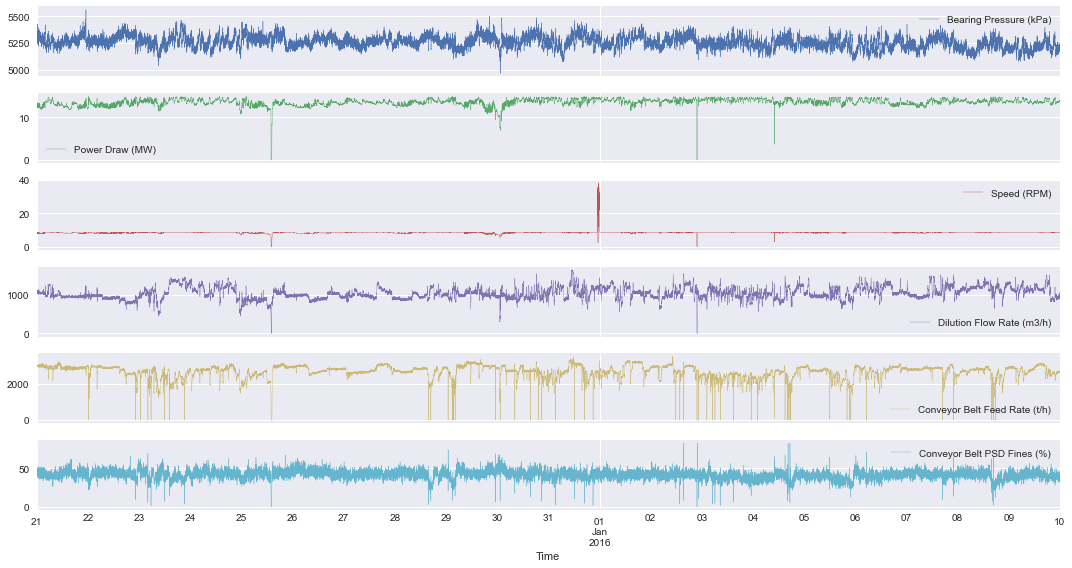

In [14]:
# Original Data
df[col].plot(subplots=True, layout=(-1, 1), lw=0.4, figsize=(15, 8))
plt.tight_layout()

### Conclusions

1. *Rotation speed of the mill > critical speed*

As specified in the instructions, speed is a control variables, which can be controlled by the operator. 

We can see an anomalous behaviour of the mill on the 31st December. These days coincide with Christmas holidays and probably there were no operators to check the machines.

Assuming that on normal days this anomalous speed would be checked, we decide to *remove* this *high peak* using *linear interpolation*.

2. Low peaks Power Draw/Speed

Low peaks of Power Draw/Speed indicate a decrease of the machine performance and they are reflected in all the other variables.

We decide to keep as indicators of normal machine operations.

## Data Preparation

The *Critical Speed* for a grinding mill is defined as the rotational speed where centrifugal forces equal gravitational forces at the mill shell's inside surface. This is the rotational speed where balls will not fall away from the mill's shell.

*Critical speed* = `15 RPM` (source: google)

The mill's measured RPM is aprox 70% of critical speed (aprox 10.5 RPM) [See the third visualization above]

In [15]:
# Limit = 15 RPM(Critical Speed)
high_speed = df[(df['Speed (RPM)'] > 15)]

In [16]:
time_high_speed = df.index[(df['Speed (RPM)'] > 15)].tolist()
print(f'High speed (31st of December): {time_high_speed[0]} - {time_high_speed[-1]}')

perc_high_speed = (len(high_speed)/len(df))*100
print(f'High speed percentage: {round(perc_high_speed,2)} %')

High speed (31st of December): 2015-12-31 23:00:00 - 2015-12-31 23:59:00
High speed percentage: 0.19 %


In [17]:
# Copy of the dataframe for linear interpolation
df_li = df.copy()

Linear interpolation to eliminate speed picks from 2015-12-31 22:59:00 to 2016-01-01 00:00:00.

In [18]:
speed_li = pd.Series(np.linspace(df_li['Speed (RPM)']['2015-12-31 22:59:00'], df_li['Speed (RPM)']['2016-01-01 00:00:00'],62))

In [19]:
df_li['Speed (RPM)']['2015-12-31 22:59:00':'2016-01-01 00:00:00'] = speed_li

### Visualizations

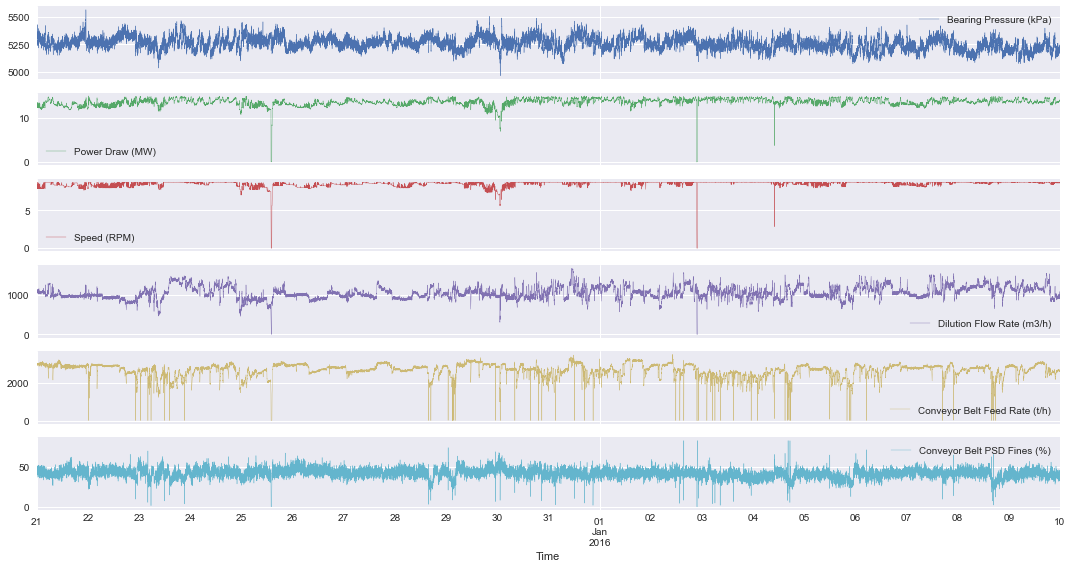

In [20]:
# Modified Data with high speeds removed
df_li.plot(subplots=True, layout=(-1, 1), lw=0.4, figsize=(15, 8))
plt.tight_layout()

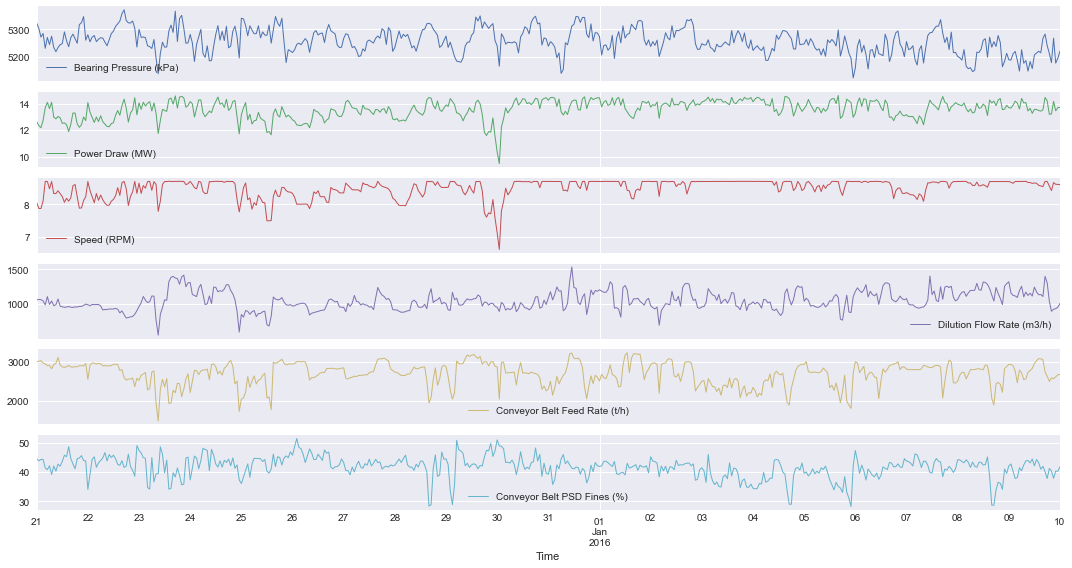

In [21]:
# Resample data (median)
df_li[col].resample("h").median().plot(subplots=True, layout=(-1, 1), lw=1, figsize=(15, 8))
plt.tight_layout()

### Save data

In [22]:
# df.to_csv('input/sag_data_EDA.csv')

## Stationarity

*Stationarity* in time series is a common assumption for forecasting techniques. A stationary process has the property that the mean, variance, and autocorrelation structure do not change over time. 

### Dickey Fuller test

We need to test all variables for stationarity performing the *Augmented Dickey Fuller test*.

We check the stationarity of the data with moving average.

In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set

Below, the *null hypothesis* and *alternative hypothesis* for the *Dickey-Fuller test*:

*H0* = process is NOT stationary (series presents a time-dependent trend)

*H1* = process is stationary (series does not depend on time)

In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set

In [23]:
def test_stationarity(ts, wd, ttl):
    
    '''Function totest the stationarity of a time series
    - ts: time series with time as index and target variable
    - wd: window for the rolling statistics test
    '''
    
    # Determing rolling statistics
    rolmean = ts.rolling(wd).mean()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original', lw=0.2)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.suptitle(ttl)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    # AIC --> The number of lags is chosen to minimize the corresponding information criterion
    dftest = adfuller(ts, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

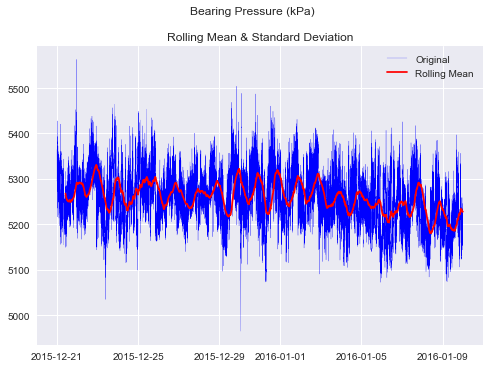

Results of Dickey-Fuller Test:
Test Statistic                -1.055545e+01
p-value                        7.974427e-19
#Lags Used                     5.000000e+01
Number of Observations Used    2.875000e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861641e+00
Critical Value (10%)          -2.566824e+00
dtype: float64


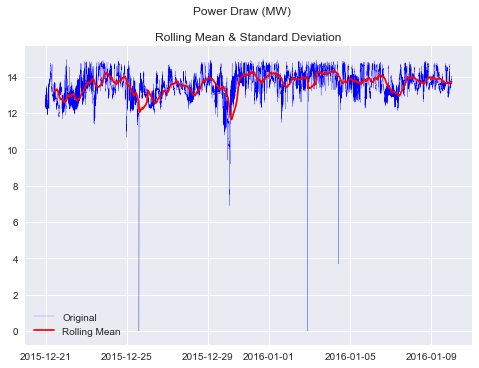

Results of Dickey-Fuller Test:
Test Statistic                -1.294845e+01
p-value                        3.416265e-24
#Lags Used                     4.200000e+01
Number of Observations Used    2.875800e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861641e+00
Critical Value (10%)          -2.566823e+00
dtype: float64


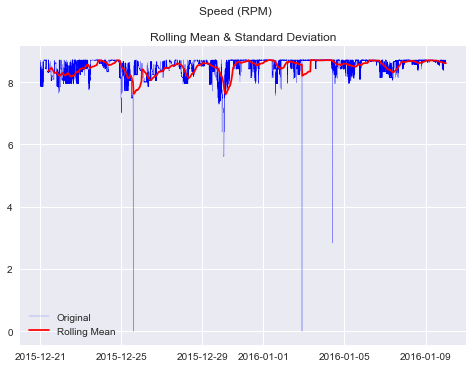

Results of Dickey-Fuller Test:
Test Statistic                -1.471458e+01
p-value                        2.813028e-27
#Lags Used                     3.800000e+01
Number of Observations Used    2.876200e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861640e+00
Critical Value (10%)          -2.566823e+00
dtype: float64


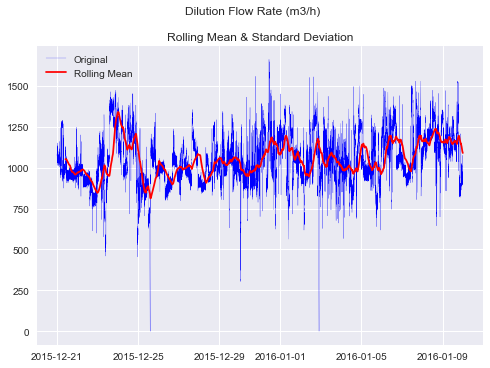

Results of Dickey-Fuller Test:
Test Statistic                -1.042085e+01
p-value                        1.706220e-18
#Lags Used                     3.900000e+01
Number of Observations Used    2.876100e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861640e+00
Critical Value (10%)          -2.566823e+00
dtype: float64


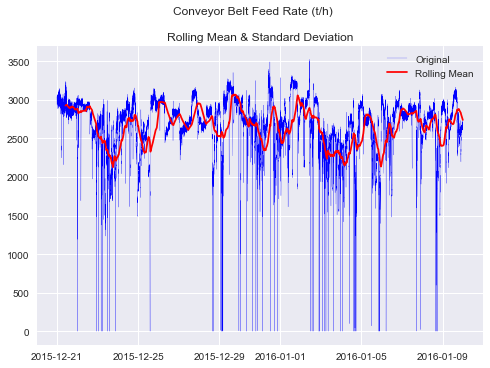

Results of Dickey-Fuller Test:
Test Statistic                -1.052714e+01
p-value                        9.354138e-19
#Lags Used                     4.400000e+01
Number of Observations Used    2.875600e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861641e+00
Critical Value (10%)          -2.566824e+00
dtype: float64


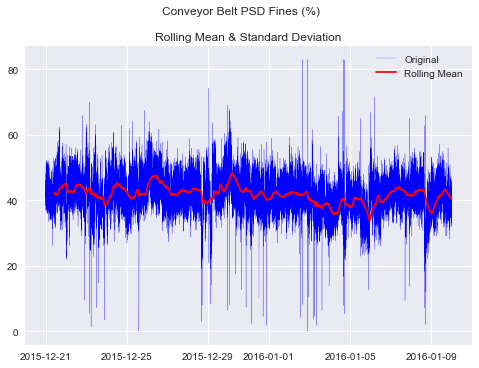

Results of Dickey-Fuller Test:
Test Statistic                -1.274953e+01
p-value                        8.594067e-24
#Lags Used                     3.700000e+01
Number of Observations Used    2.876300e+04
Critical Value (1%)           -3.430577e+00
Critical Value (5%)           -2.861640e+00
Critical Value (10%)          -2.566823e+00
dtype: float64


In [24]:
# Window: 600 min (1 day)
for c in col:
    test_stationarity(df_li[c],600,c)

### Conclusions

All the curves are *stationary* (this means are free of any trends or seasonality) because:

· P-value < 0.05 threshold

· Test-statistic > critical values

· Reject H0 (time series is stationary)

We don't need to perform other additional analysis.

## Problem Statement

Select a model to predict performance variables 5 minutes in advance.

To solve this problem we decide to use a *Long-Short-Term Memory (LSTM)*, a *recurrent neural network* trained by using Back-propagation through time and overcomes the vanishing gradient problem. 

### Input/Output

In [25]:
input = [c for c in col]
output = 5

print(f'Input: {input}')
print(f'\nOutput: {str(output)} steps (5 mins in advance)')

Input: ['Bearing Pressure (kPa)', 'Power Draw (MW)', 'Speed (RPM)', 'Dilution Flow Rate (m3/h)', 'Conveyor Belt Feed Rate (t/h)', 'Conveyor Belt PSD Fines (%)']

Output: 5 steps (5 mins in advance)


Due to the input/output structure, we think that a good model to predict performance variables 5 minutes in advance is a **Multi-Variate + Multi-Step LSTM** (multiple inputs + step wise forecasting)

Notebook:
    
- `01_LSTM`